<div >
<img src = "figures_noteboook/banner.png" />
</div>


# Regularization: Ridge

## Prediciendo precios de propiedades

El objetivo es predecir precios de propiedades

$$
Log(Precio) = F(atributos) + u
$$

proponemos

$$
Log(Precio) = \beta_0 +  \beta_1 Nro.Habitaciones +  \beta_2 Nro.Baños +  \beta_3 SuperficieTotal+ +  \beta_4 Casa + +  \beta_5 DistanciaCBD +  \beta_6 DistanciaColegio +  \beta_7 DistanciaParque +  \beta_8 IntesidadLuces2019 +  \beta_9 IntensidadLuces2021 +  \beta_10 CambioActividad + \sum_{i=1} \theta_i Localidad + u
$$


Let's load the packages and the data set:

In [1]:
# Cargamos paquetes -------------------------------------------------------
require("pacman")
p_load("tidyverse","stargazer")


Loading required package: pacman



In [2]:
# Cargar los datos --------------------------------------------------------
houses<-readRDS(url("https://github.com/ignaciomsarmiento/datasets/raw/main/data_houses_inmob.Rds"))


# Partir la muestra en entrenamiento y prueba -----------------------------
set.seed(1234)
sample_test<- sample(nrow(houses), size=nrow(houses)*0.3)

prueba<-houses[sample_test,]

entrenamiento<-houses[-sample_test,]


## Regresión Lineal

In [3]:
lr_model<-lm(log(price)~.,data=entrenamiento)

stargazer(lr_model,type="text")


                         Dependent variable:    
                     ---------------------------
                             log(price)         
------------------------------------------------
l4Barrios Unidos               0.583*           
                               (0.331)          
                                                
l4Bosa                         0.648*           
                               (0.335)          
                                                
l4Ciudad Bolívar                0.295           
                               (0.348)          
                                                
l4Engativa                      0.507           
                               (0.330)          
                                                
l4Los Mártires                  0.357           
                               (0.354)          
                                                
l4Puente Aranda                 0.226           
                   

## Lasso

Lasso regression can be fit using glmnet() with alpha = 1 and seeks to minimize

$$
\sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij}    \right) ^ 2 + \lambda \sum_{j=1}^{p} |\beta_j|.
$$

Notice that the intercept is not penalized. 



## Glmnet

To apply a regularized model we can use the `glmnet::glmnet()` function. The `alpha` parameter tells glmnet to perform a ridge (`alpha` = 0), lasso (`alpha` = 1), or elastic net (0 < `alpha` < 1) model. 

By default, `glmnet` will do two things that you should be aware of:

1. Since regularized methods apply a penalty to the coefficients, we need to ensure our coefficients are on a common scale. If not, then predictors with naturally larger values  will be penalized more than predictors with naturally smaller values. By default, `glmnet` automatically standardizes your features. If you standardize your predictors prior to glmnet you can turn this argument off with `standardize = FALSE`.

2. `glmnet` will fit ridge models across a wide range of  $\lambda$  values, which is illustrated below:

`glmnet` has some drawbacks, the main one is that we need to specify the arguments in terms of matrices and vectors:

In [4]:
p_load("glmnet")


Let's run the ridge regression (we need to set the parameter `alpha` to one)

In [5]:
X<- entrenamiento %>% select(-price) 
X<- model.matrix(price~.+ poly(rooms,2):poly(surface_total,2):poly(bathrooms,2) + dist_cole:dist_park -1,entrenamiento)
y<- log(entrenamiento$price)


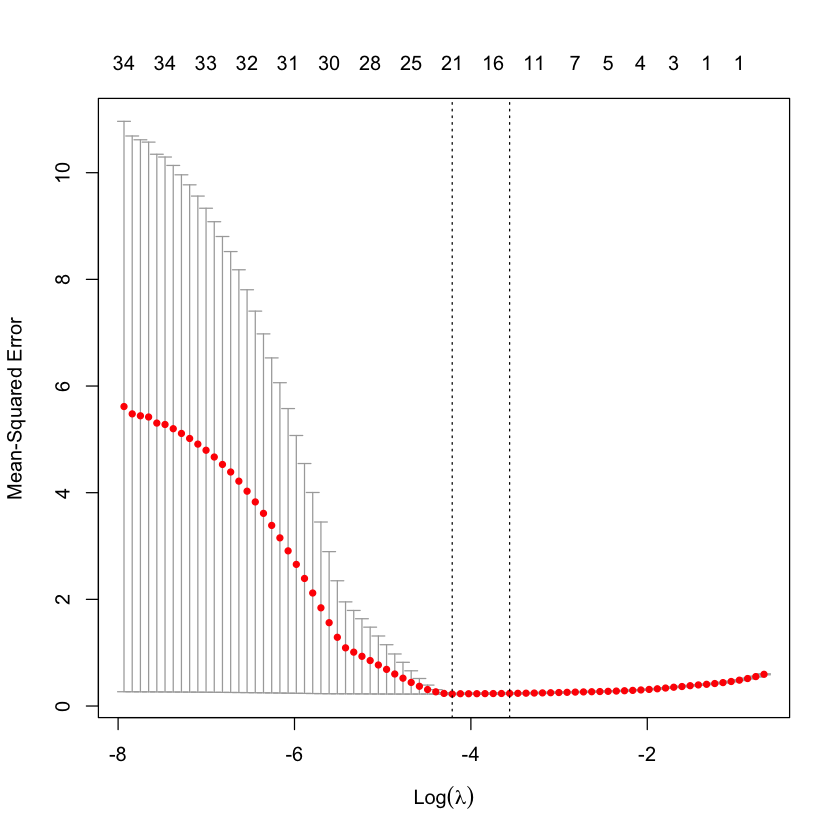

In [6]:
cv_lasso<-cv.glmnet(X, #predictores
                    y, #target (precio)
                    alpha=1 #alpha =1 es un modelo de Lasso, 0 es Ridge
                    )

plot(cv_lasso)

In [7]:
cv_lasso


Call:  cv.glmnet(x = X, y = y, alpha = 1) 

Measure: Mean-Squared Error 

     Lambda Index Measure      SE Nonzero
min 0.01482    39  0.2248 0.01192      21
1se 0.02842    32  0.2366 0.01159      15

We can plot:

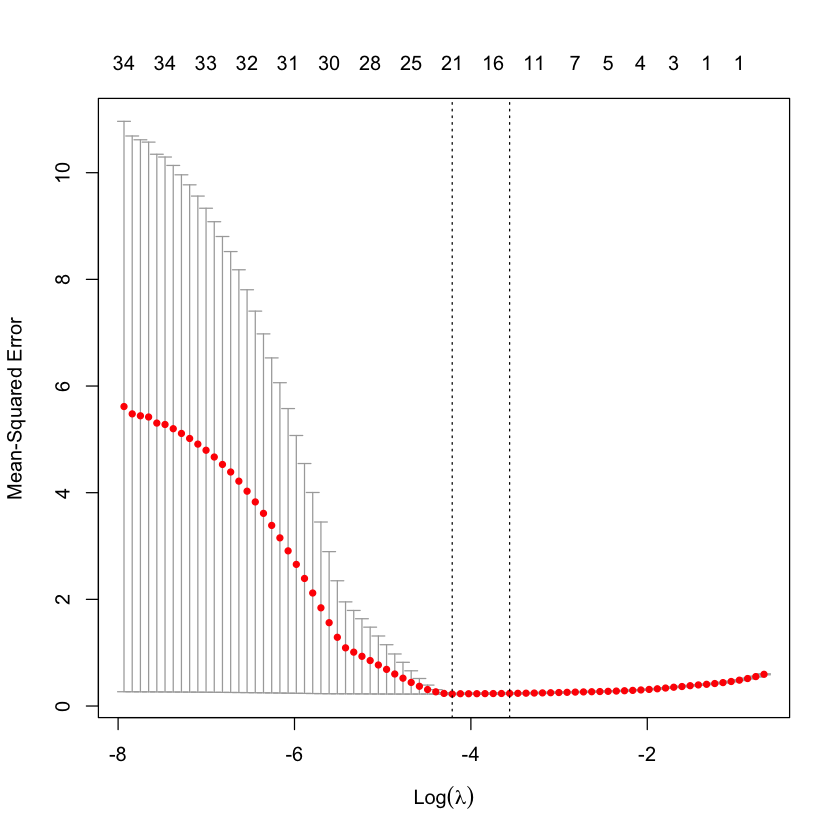

In [8]:
plot(cv_lasso)

This plots the cross-validation curve (red dotted line) along with upper and lower standard deviation curves
along the $\lambda$ sequence (error bars). 

Two special values along the $\lambda$ sequence are indicated by the vertical dotted lines:
 - lambda.min is the value of $\lambda$ that gives minimum mean cross-validated error, while 
 - lambda.1se is the value of $\lambda$ that gives the most regularized model such that the cross-validated error is within one standard error of the minimum.

We can use the following code to get the value of `lambda.min` 

In [9]:
log(cv_lasso$lambda.min)

[1] -4.211782

In [10]:
cv_lasso$lambda.min

[1] 0.01481994

and the model coefficients at that value of $\lambda$:

In [11]:
coef(cv_lasso, s = "lambda.min")

38 x 1 sparse Matrix of class "dgCMatrix"
                                                                       s1
(Intercept)                                                  2.364426e+01
l4Antonio Nariño                                             .           
l4Barrios Unidos                                             .           
l4Bosa                                                       .           
l4Ciudad Bolívar                                            -8.538880e-02
l4Engativa                                                  -1.066962e-01
l4Los Mártires                                               .           
l4Puente Aranda                                             -2.086732e-01
l4Rafael Uribe Uribe                                        -5.096504e-01
l4Teusaquillo                                                .           
l4Tunjuelito                                                -5.830242e-01
l4Usaquén                                                    2.416697e

Predictions can be made based on the fitted cv.glmnet object as well. The code below gives predictions for
the new input matrix `newx` at `lambda.min`:

In [12]:
predict(cv_lasso, newx = X[1:5,], s = "lambda.min")

,lambda.min
15,21.10914
34,20.20837
51,19.86355
52,20.84066
54,20.70893


## Ridge

Ridge regressioncan be fit using glmnet() with alpha = 0 and seeks to minimize

$$
\sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij}    \right) ^ 2 + \lambda \sum_{j=1}^{p} \beta_j^2 .
$$

Notice that the intercept is not penalized. 


Ridge penalizes the squares  of the coefficients. As a result, ridge shrinks coefficients toward zero, but not all the way.


In [14]:
cv_ridge<-cv.glmnet(X, #predictores
                     y, #target (precio)
                     alpha=0 #alpha =1 es un modelo de Lasso, 0 es Ridge
)

Warning message in plot.window(...):
“"xvar" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"xvar" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"xvar" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"xvar" is not a graphical parameter”
Warning message in box(...):
“"xvar" is not a graphical parameter”
Warning message in title(...):
“"xvar" is not a graphical parameter”


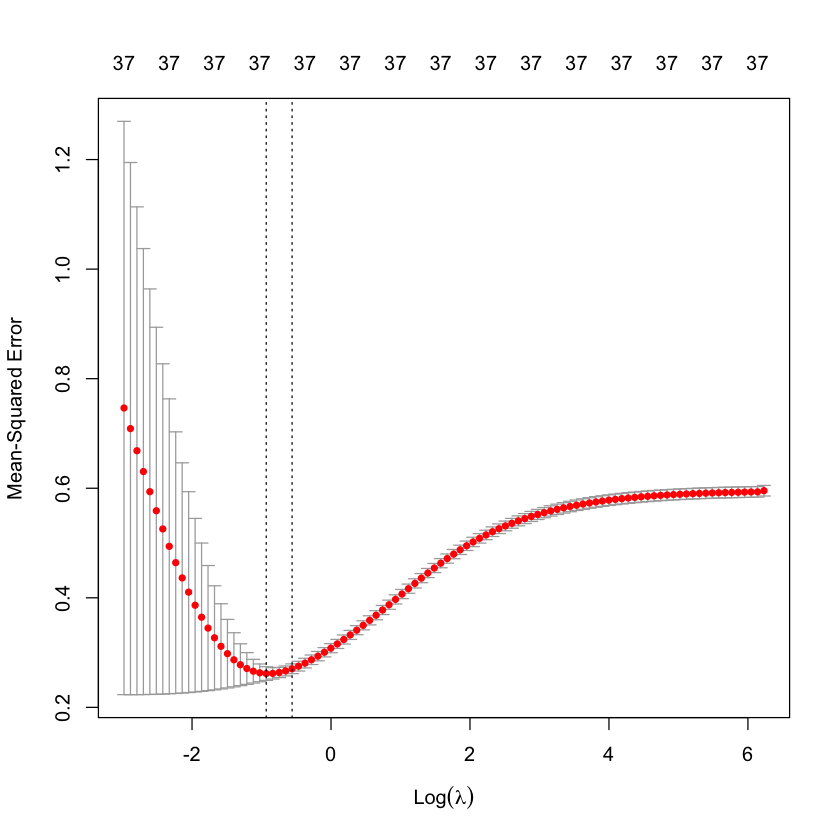

In [15]:
plot(cv_ridge, xvar = "lambda")

In [16]:
predict(cv_lasso, newx = X[1:5,], s = "lambda.min")

,lambda.min
15,21.10914
34,20.20837
51,19.86355
52,20.84066
54,20.70893



## Elastic Net 

**Es un happy medium**


\begin{align}
 \sum_{i=1}^n (y_i-\beta_0 - \sum_{j=1}^p x_{ij}\beta_j)^2  + \alpha\lambda \sum_{j=1}^p |\beta_j| + (1-\alpha)\lambda \sum_{j=1}^p (\beta_j)^2
\end{align}


- Si $\alpha=1$ Lasso
- Si $\alpha=0$ Ridge
 
 
**Como elegir $(\alpha,\lambda)$?** $\rightarrow$ Validación Cruzada Bidimensional 


In [17]:
cv.en <- cv.glmnet(
  x = X,
  y = y,
  alpha = 0.5 #EN
)

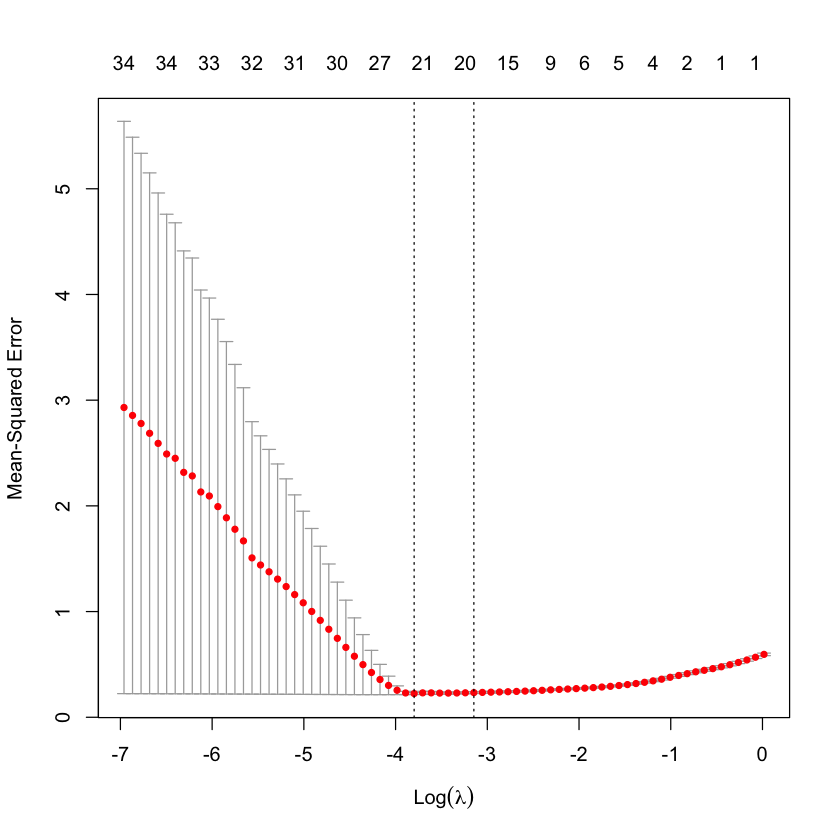

In [18]:
plot(cv.en)

## Comparación

In [19]:
# Ridge
sqrt(cv_ridge$cvm[cv_ridge$lambda == cv_ridge$lambda.min])

[1] 0.5115856

In [20]:
# Lasso
sqrt(cv_lasso$cvm[cv_lasso$lambda == cv_lasso$lambda.min])

[1] 0.4741382

In [21]:
# EN

sqrt(cv.en$cvm[cv.en$lambda == cv.en$lambda.min])

[1] 0.4737891